In [ ]:

import torch
import logging
import statistics
import torchvision.transforms as T
from accelerate import Accelerator
from yacs.config import CfgNode as CN
from main import get_config, init_accelerator, set_seed, FFPP
from src.models import Detector
logging.basicConfig(level="DEBUG")


class Obj:
    pass


c = FFPP.get_default_config()
c.pack = 1
c.augmentation = "none"
c.random_speed = True
c.compressions = ["c23"]
c.types = ["REAL", "NT"]


mc = Detector.get_default_config()
mc.out_dim = [2]
mc.decode_mode="index"
mc.decode_indices=[6,7,8,9,10,11]
mc.adapter = CN()
mc.adapter.frozen = 0
mc.adapter.struct = CN()
mc.adapter.struct.type = "768-x-768-nln"
mc.adapter.struct.x = 256
mc.adapter.type = "normal"
mc.op_mode.attn_record = True

accelerator = Accelerator(mixed_precision='no')
c

In [ ]:
model = Detector(mc, 20, accelerator).to(accelerator.device)
encoder = model.encoder
model.load_state_dict(torch.load("logs/deepfake/deepfake/best/best_weights.pt",map_location="cpu"))
model.eval()
model = model.to("cuda")
mc

In [ ]:
transform = T.Compose([
    T.Resize(encoder.input_resolution, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(encoder.input_resolution),
    T.ConvertImageDtype(torch.float32),
    T.Normalize((0.48145466, 0.4578275, 0.40821073),
                (0.26862954, 0.26130258, 0.27577711)),
])

x = FFPP(c.clone(), 20, 4, transform, accelerator, split="test")
_x = FFPP(c.clone(), 20, 4, lambda x: x, accelerator, split="test")
c

In [40]:
# vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "691_732")
# vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "851_552")
# vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "691")
# vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "089")
# vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "851")
vid_idx = 10
vid_idx 

StopIteration: 

In [ ]:
clips, label, masks, speed, meta, task_index =x[vid_idx]
clips = torch.stack(clips)
masks = torch.stack(masks)

DEBUG:root:Item/Video Index:378/86
DEBUG:root:Item DF/COMP:REAL/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/real/c23/videos/691.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0.20842105263157895
/home/od/anaconda3/envs/dfd-clip/lib/python3.8/site-packages/torchvision-0.16.0a0+657027f-py3.8-linux-x86_64.egg/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: upd

In [ ]:
torch.cuda.empty_cache()
result = []
attns = []
with torch.no_grad():
    for i in range(clips.shape[0]):
        result.append(model.predict(clips[i].unsqueeze(0).to("cuda"),masks[i].unsqueeze(0).to("cuda"))[0][0].detach().cpu())
        _attn = []
        for blk in model.decoder.transformer.resblocks:
            # effectivity =  torch.abs(blk.attn.aff.detach().cpu()).sum(dim=-1)
            effectivity =  torch.abs(blk.attn.aff.detach().cpu()).mean(dim=-1)
            norm_effectivity = effectivity / torch.max(effectivity)
            _attn.append(norm_effectivity.view(20,-1))
        attns.append(_attn)
torch.cuda.empty_cache()

In [ ]:
_clips = _x[vid_idx][0]

DEBUG:root:Item/Video Index:378/86
DEBUG:root:Item DF/COMP:REAL/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/real/c23/videos/691.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0.20842105263157895
DEBUG:root:Video: ./datasets/ffpp/real/c23/videos/691.avi, Completed!
DEBUG:root:Item/Video Index:379/86
DEBUG:root:Item DF/COMP:REAL/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/real/c23/videos/691.avi
DEBUG:root:Sample Offset: 4
DEBUG:root:Sample Stride: 0.20842105263157895
DEBUG:root:Video: ./datasets/ffpp/real/c23/videos/691.avi, Completed!
DEBUG:root:Item/Video Index:380/86
DEBUG:root:Item DF/COMP:REAL/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/real/c23/videos/691.avi
DEBUG:root:Sample Offset: 8
DEBUG:root:Sample Stride: 0.20842105263157895
DEBUG:root:Video:

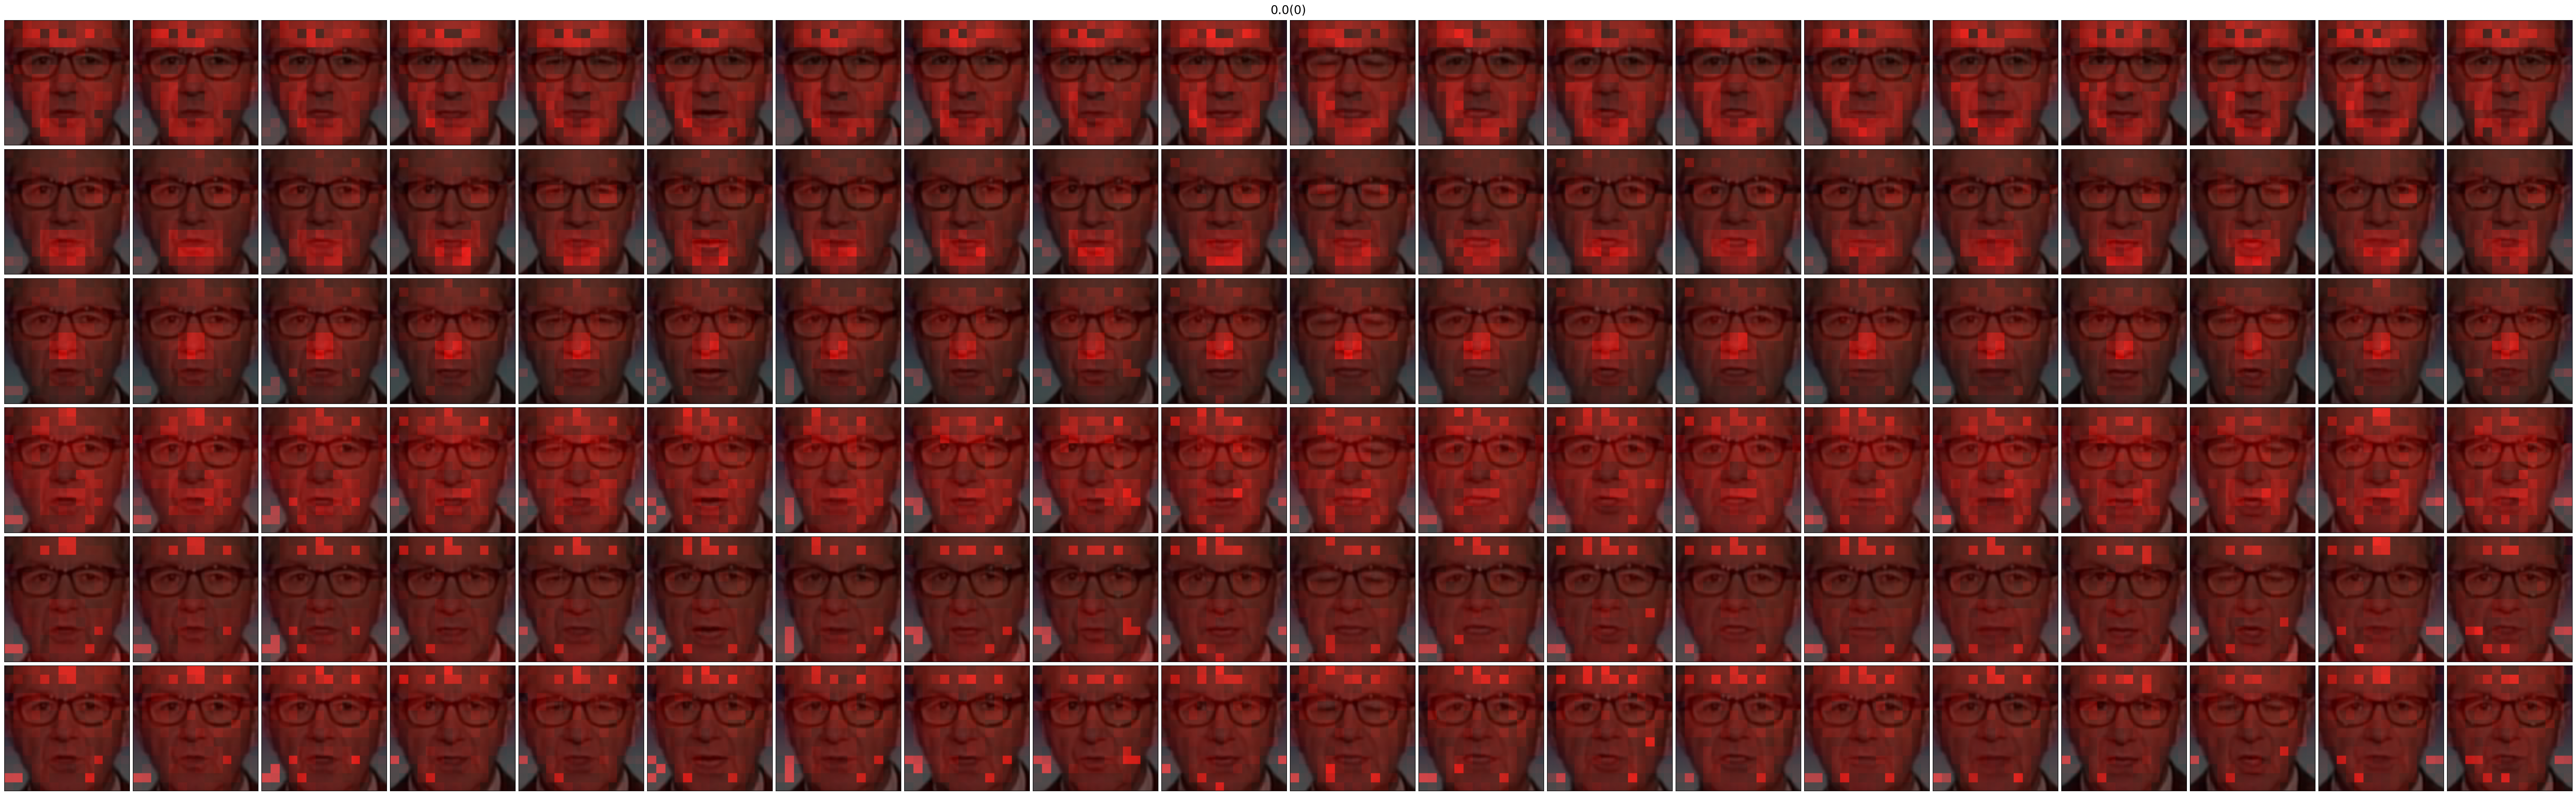

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.ioff()
unit_size = 3
image_idx = 3
imgs = _clips[image_idx].numpy().transpose((0,2,3,1))

plt.figure(figsize=(20*unit_size,12*unit_size),layout="constrained")
plt.suptitle(f"{round(result[image_idx].squeeze(0).softmax(dim=-1)[1].item(),2)}({label})",fontsize=20)
for j in range(6):
        blk_attns = attns[image_idx][j].view((20,14,14)).numpy()
        for i in range(20):
                plt.subplot(12, 20, j * 20 + i + 1)
                hmap =  cv2.resize(blk_attns[i],(150,150),interpolation=cv2.INTER_NEAREST).reshape(150,150,1)*255
                hmap = np.concatenate((hmap,np.zeros((150,150,2))),axis=-1)
                hmap = imgs[i] *0.3 + hmap*0.7
                # hmap = imgs[i]
                im = plt.imshow(hmap.astype(np.uint8))

                # Show all ticks and label them with the respective list entries
                plt.gca().set_xticks([])
                plt.gca().set_yticks([])
plt.show()